# Programming Assignment 2: Analyzing Product Sentiment

Use a set of key polarizing words and verify their corresponding weights to train a sentiment analysis model. Then, compare the results of this classifier with those of one using all of the words.

In [13]:
import re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from collections import Counter

A subset of key polarizing words:

In [14]:
selected_words = ['awesome', 'great', 'fantastic', 'amazing', 'love', 'horrible', 'bad', 'terrible', 'awful', 'wow', 'hate']

#### Preview the data

In [15]:
products = pd.read_csv("data/amazon_baby.csv")
print("There are " + str(products.shape[0]) + " entries and " + str(products.shape[1]) + " columns.")
products.head()
# products.sample(n=3, random_state=0)

There are 183531 entries and 3 columns.


,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


## Task 1: Build a new feature with the counts for each of the selected words
The task is to create a new column in the products DataFrame with the counts for each selected_word above. 

In [16]:
def count_words(sentence):
    # Convert sentence to lower-case, and remove punctuations
    sentence = re.sub('\\.|\\,|\\!|\\?| -', '', sentence.lower())
    
    # Count words in sentence
    word_count = Counter(sentence.split())
    
    return word_count

def count_target_words(sent_counter, selected_words):
    sent_targets = {}
    
    for word in selected_words:
        if word in sent_counter:
            sent_targets[word] = sent_counter[word]
        else:
            sent_targets[word] = 0
            
    return sent_targets

In [17]:
# This is the function that will be used together with .apply()
def count(row):
    sentence = row['review']
    
    # Convert sentence to lower-case, and remove punctuations
    sentence = re.sub('\\.|\\,|\\!|\\?| -', '', sentence.lower())
    
    # Count words in sentence
    word_count = Counter(sentence.split())
    
    return word_count

# This is the function to use together with .apply() to get word count of selected words
def count_selected(row, word_list = selected_words):
    sentence = row['review']
    
    # Convert sentence to lower-case, and remove punctuations
    sentence = re.sub('\\.|\\,|\\!|\\?| -', '', sentence.lower())
    
    # Count words in sentence
    word_count = Counter(sentence.split())
    
    # Initialize empty dict to store count of selected words
    sent_targets = {}
    
    for word in word_list:
        if word in word_count:
            sent_targets[word] = word_count[word]
        else:
            sent_targets[word] = 0
            
    return Counter(sent_targets)

If the functions in the cell above are directly used on the original dataframe, it will raise <code>AttributeError: 'float' object has no attribute 'lower'</code> because there are empty cells with NaN values. One solution is to remove the rows with empty cells in the review column, another solution is to replace NaN values with an empty string.

For more information, see [this page](https://stackoverflow.com/questions/42224700/attributeerror-float-object-has-no-attribute-split).

In [18]:
p1 = products.copy(deep=True) # Make a copy of the original dataframe

# If the function count() is directly applied on the dataframe, it will raise
# AttributeError: 'float' object has no attribute 'lower' because the column
# 'review' have cells with NaN values. 

# Must remove these empty cells before calling .apply()
p1 = p1[p1['review'].notnull()]

# Get word count
# p1['word_count'] = p1.apply(count, axis = 1)

# Get word count of selected words
p1['selected_count'] = p1.apply(count_selected, axis = 1)
p1.head()

,name,review,rating,selected_count
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,"{'awesome': 0, 'great': 0, 'fantastic': 0, 'am..."
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,"{'awesome': 0, 'great': 0, 'fantastic': 0, 'am..."
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,"{'awesome': 0, 'great': 0, 'fantastic': 0, 'am..."
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,"{'awesome': 0, 'great': 0, 'fantastic': 0, 'am..."
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,"{'awesome': 0, 'great': 1, 'fantastic': 0, 'am..."


#### Quiz Question 1: 
Use .sum() method on each of the new columns created and answer the following question: out of the <code>selected_words</code>, which one is most used in the dataset? Which one is least used?
*Save these results to answer the quiz at the end.*

In [19]:
def sum_counts(counter_series): # Recursive function with runtime O(log(n))
    
    if len(counter_series) > 10:
        counter_first = sum_counts(counter_series[:int(len(counter_series)/2)])
        counter_second = sum_counts(counter_series[int(len(counter_series)/2):])
        return sum([counter_first, counter_second], Counter())
    
    else:
        return sum(counter_series, Counter())

sum_all_entries = sum_counts(p1['selected_count'])

print(sum_all_entries)

# Get the most common keyword in dataset
most_common = sum_all_entries.most_common(1)
print('The most common keyword in this dataset is '+ str(most_common[0][0]) + ' and its count is ' + str(most_common[0][1]) + '.')

# Get the least common keyword in dataset
least_common = sum_all_entries.most_common()[-1]
print('The least common keyword in this dataset is ' + str(least_common[0]) + ' and its count is ' + str(least_common[1]) + '.')

Counter({'great': 57637, 'love': 43185, 'bad': 4658, 'awesome': 3841, 'amazing': 2609, 'fantastic': 1682, 'hate': 1247, 'terrible': 1219, 'horrible': 1199, 'awful': 711, 'wow': 382})
The most common keyword in this dataset is great and its count is 57637.
The least common keyword in this dataset is wow and its count is 382.


## Task 2: Create a new sentiment analysis model using only the <code>selected_words</code> as features

- Split the dataset into train and test sets
- Train a logistic regression classifier using just the selected words
- Examine the weights the learned classifier assigned to each of the words in selected_words

#### Define what is positive and negative sentiment
- Ignore all reviews with 3 stars
- If more than 3 stars, positive review

In [20]:
#ignore all 3*  reviews
p1 = p1[p1['rating']!= 3]

#positive sentiment = 4-star or 5-star reviews
p1['sentiment'] = p1['rating'] >= 4

p1.sample(n=3, random_state=0)

,name,review,rating,selected_count,sentiment
125405,"UPPAbaby G-Luxe Stroller, Jake/Black",This stroller is AMAZING! We needed something...,5,"{'awesome': 0, 'great': 1, 'fantastic': 0, 'am...",True
8633,Inclined to Sleep,We bought this for my son (he had bad reflux)....,1,"{'awesome': 0, 'great': 0, 'fantastic': 0, 'am...",False
53155,"Bright Starts Rattle and Shake Barbell Rattle,...",This rattle is fantastic. It\'s easy for smal...,5,"{'awesome': 0, 'great': 0, 'fantastic': 1, 'am...",True


#### Pre-process data

In [21]:
p2 = p1[['selected_count', 'sentiment']].copy()
p2['sentiment'] = p2['sentiment'].replace([True, False], [1, 0])
p2.sample(n=5, random_state=0)

,selected_count,sentiment
125405,"{'awesome': 0, 'great': 1, 'fantastic': 0, 'am...",1
8633,"{'awesome': 0, 'great': 0, 'fantastic': 0, 'am...",0
53155,"{'awesome': 0, 'great': 0, 'fantastic': 1, 'am...",1
90419,"{'awesome': 0, 'great': 0, 'fantastic': 0, 'am...",1
179352,"{'awesome': 0, 'great': 0, 'fantastic': 0, 'am...",1


In [22]:
def vectorize(row, key):
    counter = row['selected_count']
    return counter[key]
   
for keyword in selected_words:
    p2[keyword] = p2.apply(vectorize, axis=1, key=keyword)
    
p2.head()

,selected_count,sentiment,awesome,great,fantastic,amazing,love,horrible,bad,terrible,awful,wow,hate
1,"{'awesome': 0, 'great': 0, 'fantastic': 0, 'am...",1,0,0,0,0,1,0,0,0,0,0,0
2,"{'awesome': 0, 'great': 0, 'fantastic': 0, 'am...",1,0,0,0,0,0,0,0,0,0,0,0
3,"{'awesome': 0, 'great': 0, 'fantastic': 0, 'am...",1,0,0,0,0,2,0,0,0,0,0,0
4,"{'awesome': 0, 'great': 1, 'fantastic': 0, 'am...",1,0,1,0,0,0,0,0,0,0,0,0
5,"{'awesome': 0, 'great': 1, 'fantastic': 0, 'am...",1,0,1,0,0,0,0,0,0,0,0,0


#### Split the data into train and test set

In [23]:
train, test = train_test_split(p2, test_size=0.2, random_state=1)

In [24]:
def df_to_array(dataframe, features, output=['sentiment']):
    """
    Parameters
    ----------
    dataframe: pandas DataFrame
        train or test set
    features: list of strings
        features used to predict sales price of house
    output: list of strings
        the observation variable
    """
    df1 = dataframe.copy(deep=True)
    inputs_array = df1[features].to_numpy()
    targets_array = df1[output].to_numpy()
    return inputs_array, targets_array

def arr_to_tensor(inputs_array, targets_array):
    """
    Parameters
    ----------
    inputs_array: numpy array
    targets_array: numpy array
    """
    inputs_train = torch.from_numpy(inputs_array).float()
    targets_train = torch.from_numpy(targets_array).float()
    return inputs_train, targets_train

inputs_array, targets_array = df_to_array(train, selected_words)
inputs_train, targets_train = arr_to_tensor(inputs_array, targets_array)
inputs_train, targets_train

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.]]),
 tensor([[1.],
         [1.],
         [0.],
         ...,
         [1.],
         [1.],
         [1.]]))

#### Initializing the model
- Assign some hyper-parameters

In [25]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [55]:
num_epochs = 30
input_dim = 11
output_dim = 1 # Binary output
learning_rate = 0.01

model = LogisticRegression(input_dim, output_dim)

#### Initializing the loss function and the optimizer

In [56]:
criterion = torch.nn.BCELoss() # Binary Cross Entropy Loss
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### Training the model

In [57]:
def trainModel(model, x_train, y_train, epochs):
    for epoch in range(epochs):
        # Clear buffer
        optimizer.zero_grad()
        
        y_prediction = model(x_train)
        
        loss = criterion(y_prediction, y_train)
        
        loss.backward()
        
        optimizer.step() # Update weights and biases with the optimizer (SGD)
        
        print('epoch {}, loss {}'.format(epoch, loss.item()))
        
        
trainModel(model, inputs_train, targets_train, num_epochs)

epoch 0, loss 0.5683707594871521
epoch 1, loss 0.5676353573799133
epoch 2, loss 0.5669043064117432
epoch 3, loss 0.5661774277687073
epoch 4, loss 0.5654546022415161
epoch 5, loss 0.5647359490394592
epoch 6, loss 0.5640214681625366
epoch 7, loss 0.5633110404014587
epoch 8, loss 0.5626044869422913
epoch 9, loss 0.5619021058082581
epoch 10, loss 0.5612035989761353
epoch 11, loss 0.5605091452598572
epoch 12, loss 0.5598185658454895
epoch 13, loss 0.5591319799423218
epoch 14, loss 0.5584492087364197
epoch 15, loss 0.557770311832428
epoch 16, loss 0.5570951700210571
epoch 17, loss 0.5564239621162415
epoch 18, loss 0.5557565093040466
epoch 19, loss 0.5550926923751831
epoch 20, loss 0.5544328689575195
epoch 21, loss 0.5537764430046082
epoch 22, loss 0.553123950958252
epoch 23, loss 0.552475094795227
epoch 24, loss 0.5518298149108887
epoch 25, loss 0.551188051700592
epoch 26, loss 0.5505500435829163
epoch 27, loss 0.5499154925346375
epoch 28, loss 0.5492845177650452
epoch 29, loss 0.54865705966

#### Quiz Question 2: 
Using this approach, sort the learned coefficients according to the 'value' column using .sort(). Out of the 11 words, which one got the most positive weight? Which one got the most negative weight? Do these values make sense?
*Save the results to answer the quiz at the end.*

In [58]:
for name, param in model.named_parameters():
    print(name)
    print(param)

linear.weight
Parameter containing:
tensor([[-0.0435,  0.3114, -0.1761, -0.1907,  0.1235, -0.0531, -0.2504, -0.0221,
         -0.1623,  0.1119, -0.2531]], requires_grad=True)
linear.bias
Parameter containing:
tensor([0.3641], requires_grad=True)


In [59]:
selected_words = ['awesome', 'great', 'fantastic', 'amazing', 'love', 'horrible', 'bad', 'terrible', 'awful', 'wow', 'hate']

#### Calculate Accuracy
What is the accuracy of the selected_words_model on test data?  What was the accuracy of the sentiment_model that we learned using all the word counts in the Jupyter Notebook above from the lectures?  What is the accuracy majority class classifier on this task?  How do you compare the different learned models with the baseline approach where we are just predicting the majority class? *Save these results to answer the quiz at the end.*

In [60]:
x_test_arr, y_test_arr = df_to_array(test, selected_words)
x_test, y_test = arr_to_tensor(x_test_arr, y_test_arr)

In [64]:
with torch.no_grad():
    y_pred = model(x_test)
    y_pred_class = y_pred.round()
    accuracy = (y_pred_class.eq(y_test).sum())/float(y_test.shape[0])
    print(accuracy.item())
    cm = confusion_matrix(y_test, y_pred_class)
    print(cm)

0.8398553729057312
[[   46  5267]
 [   49 27833]]


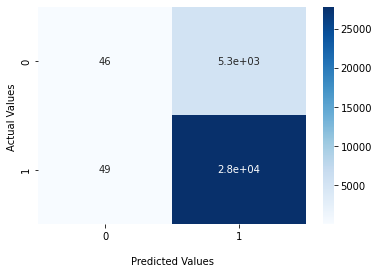

In [62]:
cfmp = sn.heatmap(cm, annot=True, cmap='Blues')
cfmp.set_xlabel('\nPredicted Values')
cfmp.set_ylabel('Actual Values ');

plt.show()

## Sources
[Logistic Regression with PyTorch](https://towardsdatascience.com/logistic-regression-with-pytorch-3c8bbea594be)

[PyTorch Loss Function Cheatsheat](https://github.com/rasbt/stat479-deep-learning-ss19/blob/master/other/pytorch-lossfunc-cheatsheet.md)